In [326]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [327]:
class SimpleMLP(nn.Module):
    def __init__(self, hidden=128, act=nn.ReLU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X.shape[-1], hidden),
            act(),
            nn.Linear(hidden, hidden),
            act(),
            nn.Linear(hidden, hidden),
            act(),
            nn.Linear(hidden, 10)  # 10 output classes
        )

        
    def forward(self, x):
        return self.net(x)  # logits

In [328]:
# 2. Generate 100 4D samples from a Gaussian distribution with mean 0 and variance 1
X = torch.randn(100, 4)

In [329]:
psi = [1,-1,2,-2,3]

In [330]:
# generate y
y = (psi[0] + psi[1]*X[:,0] + psi[2]*X[:,1] + psi[3]*X[:,2] + psi[4]*X[:,3]).clone().detach().reshape(-1,1)

# add noise from Gaussain distribution with mean 0 and variance 0.1
y += torch.randn(100, 1) * 0.1

In [331]:
y.shape

torch.Size([100, 1])

In [332]:
# 3. Put this dataset in a DataLoader with a batch size of 10.
data = TensorDataset(X, y)
dl = DataLoader(data, batch_size=10, shuffle=True)
dl_batch_1 = DataLoader(data, batch_size=1, shuffle=True)


In [333]:
# Create a model that takes 4D input and returns 1D output
class linear_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 1)
        
    def forward(self, x):
        return self.linear(x)

In [334]:
model = linear_model()
criterion = nn.MSELoss()
nn.init.kaiming_normal_(model.linear.weight, nonlinearity='linear')
nn.init.zeros_(model.linear.bias)

Parameter containing:
tensor([0.], requires_grad=True)

In [335]:
# check the initial params
for name, param in model.named_parameters():
    print(name, param)

linear.weight Parameter containing:
tensor([[-0.2769, -0.3824, -0.5975,  0.4710]], requires_grad=True)
linear.bias Parameter containing:
tensor([0.], requires_grad=True)


In [336]:
# 5. Without using an optimizer, manually update the parameters with a learning rate of 0.01.
# learning rate
a = 0.01 
beta= 0.995

loss_record = []
gradient_record = []
sqaured_gradient_record = []
grad = []
momentum_weight = torch.tensor([[0,0,0,0]])
momentum_bias = torch.tensor([0])


for epoch in range(100):
    for Xb, yb in dl:
        loss = criterion(model(Xb), yb)
        loss.backward()
        with torch.no_grad():
            grad = []
            for p in model.parameters():
                if p is model.linear.weight:
                    grad.extend(item for item in (p.grad.tolist()))
                    momentum_weight = beta * momentum_weight + (1 - beta) * p.grad
                    p -= momentum_weight * a
                    p.grad.zero_()
                else:
                    grad.append(p.grad.item())
                    momentum_bias = beta * momentum_bias + (1 - beta) * p.grad
                    p -= momentum_bias * a
                    p.grad.zero_()
            grad = [grad[1]] + grad[0]
            gradient_record.append(grad)
    loss_record.append(loss.item())

gradient_record = np.array(gradient_record)
sqaured_gradient_record = np.square(gradient_record)

In [337]:
# check the parmas after training
for name, param in model.named_parameters():
    print(name, param)

linear.weight Parameter containing:
tensor([[-1.0565,  2.2011, -2.1762,  3.0790]], requires_grad=True)
linear.bias Parameter containing:
tensor([0.9680], requires_grad=True)


In [338]:
def plot_result(loss_record, gradient_record, sqaured_gradient_record):
    
    # plot loss 
    plt.plot(loss_record, label='loss')
    # set log scale
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # plot the gradient over time
    for phi in range (5):
        plt.plot(gradient_record[:,phi], label=f'$\\phi_{phi}$')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient')
    plt.legend()
    plt.show()

    # plot the squared gradient over time 
    for phi in range (5):
        plt.plot(sqaured_gradient_record[:,phi], label=f'$\\phi_{phi}$')
    plt.xlabel('Epoch')
    plt.ylabel('Squared Gradient')
    plt.legend()
    plt.show()

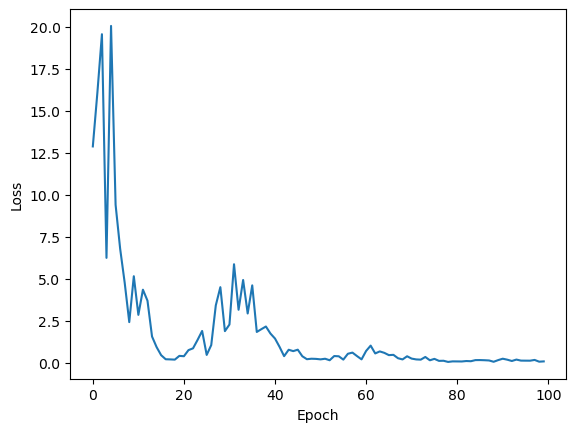

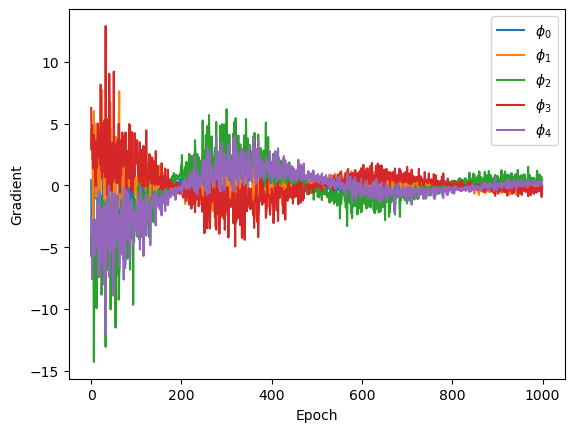

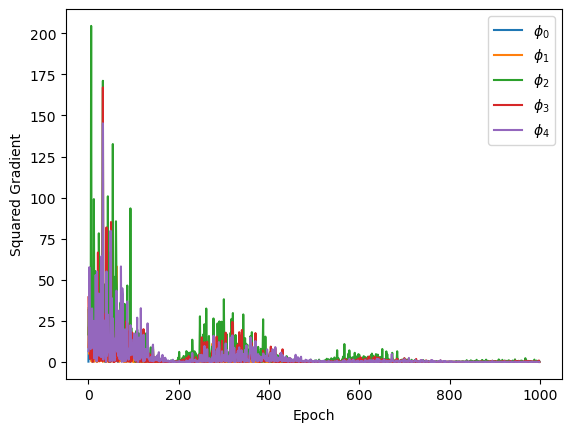

In [339]:
plot_result(loss_record, gradient_record, sqaured_gradient_record)

### Retrain with batch size = 1

In [340]:
# reset the model and the 
model = linear_model()
criterion = nn.MSELoss()
nn.init.kaiming_normal_(model.linear.weight, nonlinearity='linear')
nn.init.zeros_(model.linear.bias)

Parameter containing:
tensor([0.], requires_grad=True)

In [341]:
# check the initial params
for name, param in model.named_parameters():
    print(name, param)

linear.weight Parameter containing:
tensor([[ 0.4776, -0.3572,  0.0556,  0.3956]], requires_grad=True)
linear.bias Parameter containing:
tensor([0.], requires_grad=True)


In [342]:
# 5. Without using an optimizer, manually update the parameters with a learning rate of 0.01.
# learning rate
a = 0.01 
beta= 0.99

loss_record = []
gradient_record = []
sqaured_gradient_record = []
grad = []
momentum_weight = torch.tensor([[0,0,0,0]])
momentum_bias = torch.tensor([0])


for epoch in range(100):
    for Xb, yb in dl_batch_1:
        loss = criterion(model(Xb), yb)
        loss.backward()
        with torch.no_grad():
            grad = []
            for p in model.parameters():
                if p is model.linear.weight:
                    grad.extend(item for item in (p.grad.tolist()))
                    momentum_weight = beta * momentum_weight + (1 - beta) * p.grad
                    p -= momentum_weight * a
                    p.grad.zero_()
                else:
                    grad.append(p.grad.item())
                    momentum_bias = beta * momentum_bias + (1 - beta) * p.grad
                    p -= momentum_bias * a
                    p.grad.zero_()
            grad = [grad[1]] + grad[0]
            gradient_record.append(grad)
    loss_record.append(loss.item())

gradient_record = np.array(gradient_record)
sqaured_gradient_record = np.square(gradient_record)

In [343]:
# trim down the gradient record to every 100th element
gradient_record = gradient_record[::100]
sqaured_gradient_record = sqaured_gradient_record[::100]

In [344]:
# check the parmas after training
for name, param in model.named_parameters():
    print(name, param)

linear.weight Parameter containing:
tensor([[-1.0015,  2.0039, -1.9983,  3.0044]], requires_grad=True)
linear.bias Parameter containing:
tensor([1.0090], requires_grad=True)


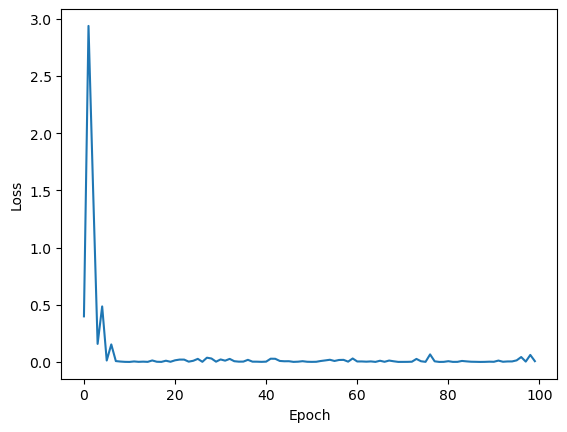

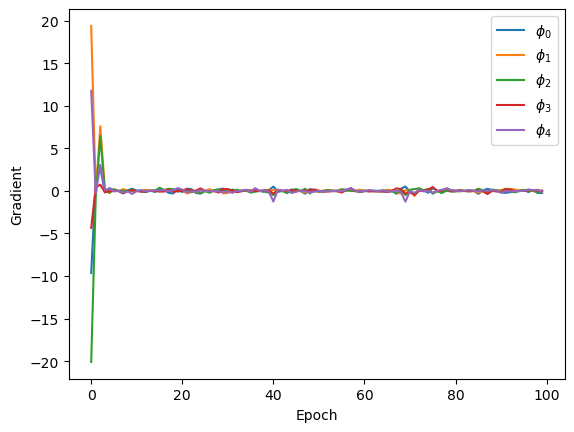

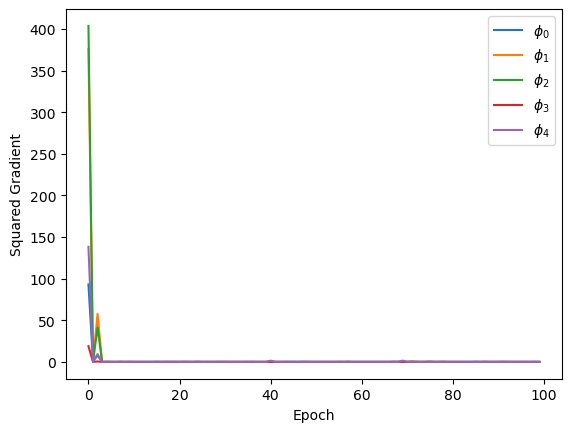

In [345]:
plot_result(loss_record, gradient_record, sqaured_gradient_record)